<a href="https://colab.research.google.com/github/Narissarach/Project_eye/blob/main/Train%20fruit3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import PIL
import time
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pickle as p
import plotly
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import plotly.graph_objs as go
from tensorflow import keras
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## เตรียมชุดของข้อมูล

In [3]:
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/0fruit')

In [4]:
batch_size = 15   # กำหนดขนาดของแต่ละการอ่านข้อมูล
img_height = 150  # ความสูงของรูปภาพแต่ละรูป
img_width = 150   # ความกว้างของรูปภาพแต่ละรูป

In [5]:
image_count = len(list(data_dir.glob('*/*.png')))
print("จำนวนรูปภาพทั้งหมด = ",image_count)

จำนวนรูปภาพทั้งหมด =  45


## Train

In [9]:
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.2, # s แบ่งข้อมูล เพื่อ training 80% และ validation 20%
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)
val = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

Found 45 files belonging to 3 classes.
Using 36 files for training.
Found 45 files belonging to 3 classes.
Using 9 files for validation.


In [8]:
class_names = train.class_names
print(class_names)

['apple', 'mangosteen', 'pineapple']


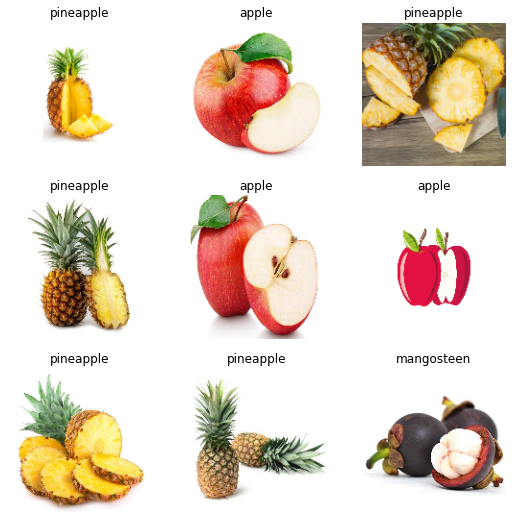

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9)) #ขนาด
for images, labels in train.take(1):
  for i in range(9): #มี 9 รูป
    ax = plt.subplot(3, 3, i + 1) #แถวละ 3
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(15, 150, 150, 3)
(15,)


## Normalization

In [13]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.03417491 1.0


## Model

In [14]:
num_classes = 3
epochs=20   # จำนวนครั้งที่เราจะ Train

In [15]:
model = Sequential([
layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Conv2D(16, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(32, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Conv2D(64, 3, padding='same', activation='relu'),
layers.MaxPooling2D(),
layers.Flatten(),
layers.Dense(128, activation='relu'),
layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [17]:
his = model.fit(
train,
validation_data=val,
epochs=epochs
)

Epoch 1/20
3/3 [==============================] - 10s 3s/step - loss: 1.5741 - accuracy: 0.3611 - val_loss: 1.7717 - val_accuracy: 0.1111
Epoch 2/20
3/3 [==============================] - 2s 384ms/step - loss: 1.2303 - accuracy: 0.3889 - val_loss: 1.0348 - val_accuracy: 0.4444
Epoch 3/20
3/3 [==============================] - 2s 383ms/step - loss: 1.0814 - accuracy: 0.3056 - val_loss: 0.9726 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 2s 389ms/step - loss: 0.9947 - accuracy: 0.5278 - val_loss: 1.0205 - val_accuracy: 0.4444
Epoch 5/20
3/3 [==============================] - 2s 379ms/step - loss: 0.8678 - accuracy: 0.6111 - val_loss: 0.8062 - val_accuracy: 0.5556
Epoch 6/20
3/3 [==============================] - 2s 484ms/step - loss: 0.6767 - accuracy: 0.6944 - val_loss: 0.6646 - val_accuracy: 0.5556
Epoch 7/20
3/3 [==============================] - 4s 677ms/step - loss: 0.4917 - accuracy: 0.9167 - val_loss: 0.7447 - val_accuracy: 0.6667
Epoch 8/20
3/3 [======

## Save Model

In [18]:
with open('history_model', 'wb') as file:
   p.dump(his.history, file)

filepath='model1.h5'
model.save(filepath)
filepath_model = 'model1.json'
filepath_weights = 'weights_model.h5'
model_json = model.to_json()
with open(filepath_model, "w") as json_file:
   json_file.write(model_json)

model.save_weights('weights_model.h5')
print("Saved model to disk")

Saved model to disk


## Load Model

In [19]:
with open('history_model', 'rb') as file:
   his = p.load(file)

h1 = go.Scatter(y=his['loss'],
mode="lines", line=dict(
width=2,
color='blue'),
name="loss"
)
h2 = go.Scatter(y=his['val_loss'],
mode="lines", line=dict(
width=2,
color='red'),
name="val_loss"
)

data = [h1,h2]
layout1 = go.Layout(title='Loss',
xaxis=dict(title='epochs'),
yaxis=dict(title=' '))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1, filename="testMNIST")
predict_model = load_model(filepath)
predict_model.summary()
with open(filepath_model, 'r') as f:
   loaded_model_json = f.read()
predict_model = model_from_json(loaded_model_json)
predict_model.load_weights(filepath_weights)
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

## Prediction

1/1 [==============================] - 0s 26ms/step
apple tf.Tensor(0.9988084, shape=(), dtype=float32) mangosteen tf.Tensor(5.267025e-05, shape=(), dtype=float32) pineapple tf.Tensor(0.001139041, shape=(), dtype=float32)


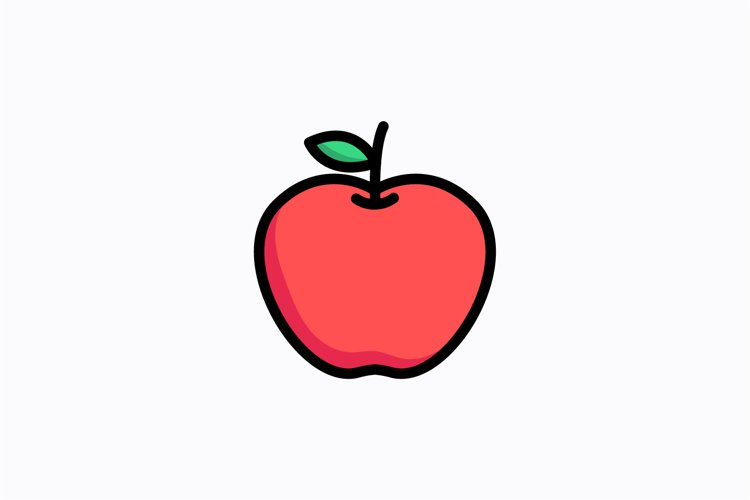

AI apple มีความมั่นใจ 99.88%.


In [21]:
import requests
from IPython.display import Image
from io import BytesIO
test_path = ('/content/drive/My Drive/a1.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 29ms/step
apple tf.Tensor(0.9999958, shape=(), dtype=float32) mangosteen tf.Tensor(4.6482523e-07, shape=(), dtype=float32) pineapple tf.Tensor(3.6724637e-06, shape=(), dtype=float32)


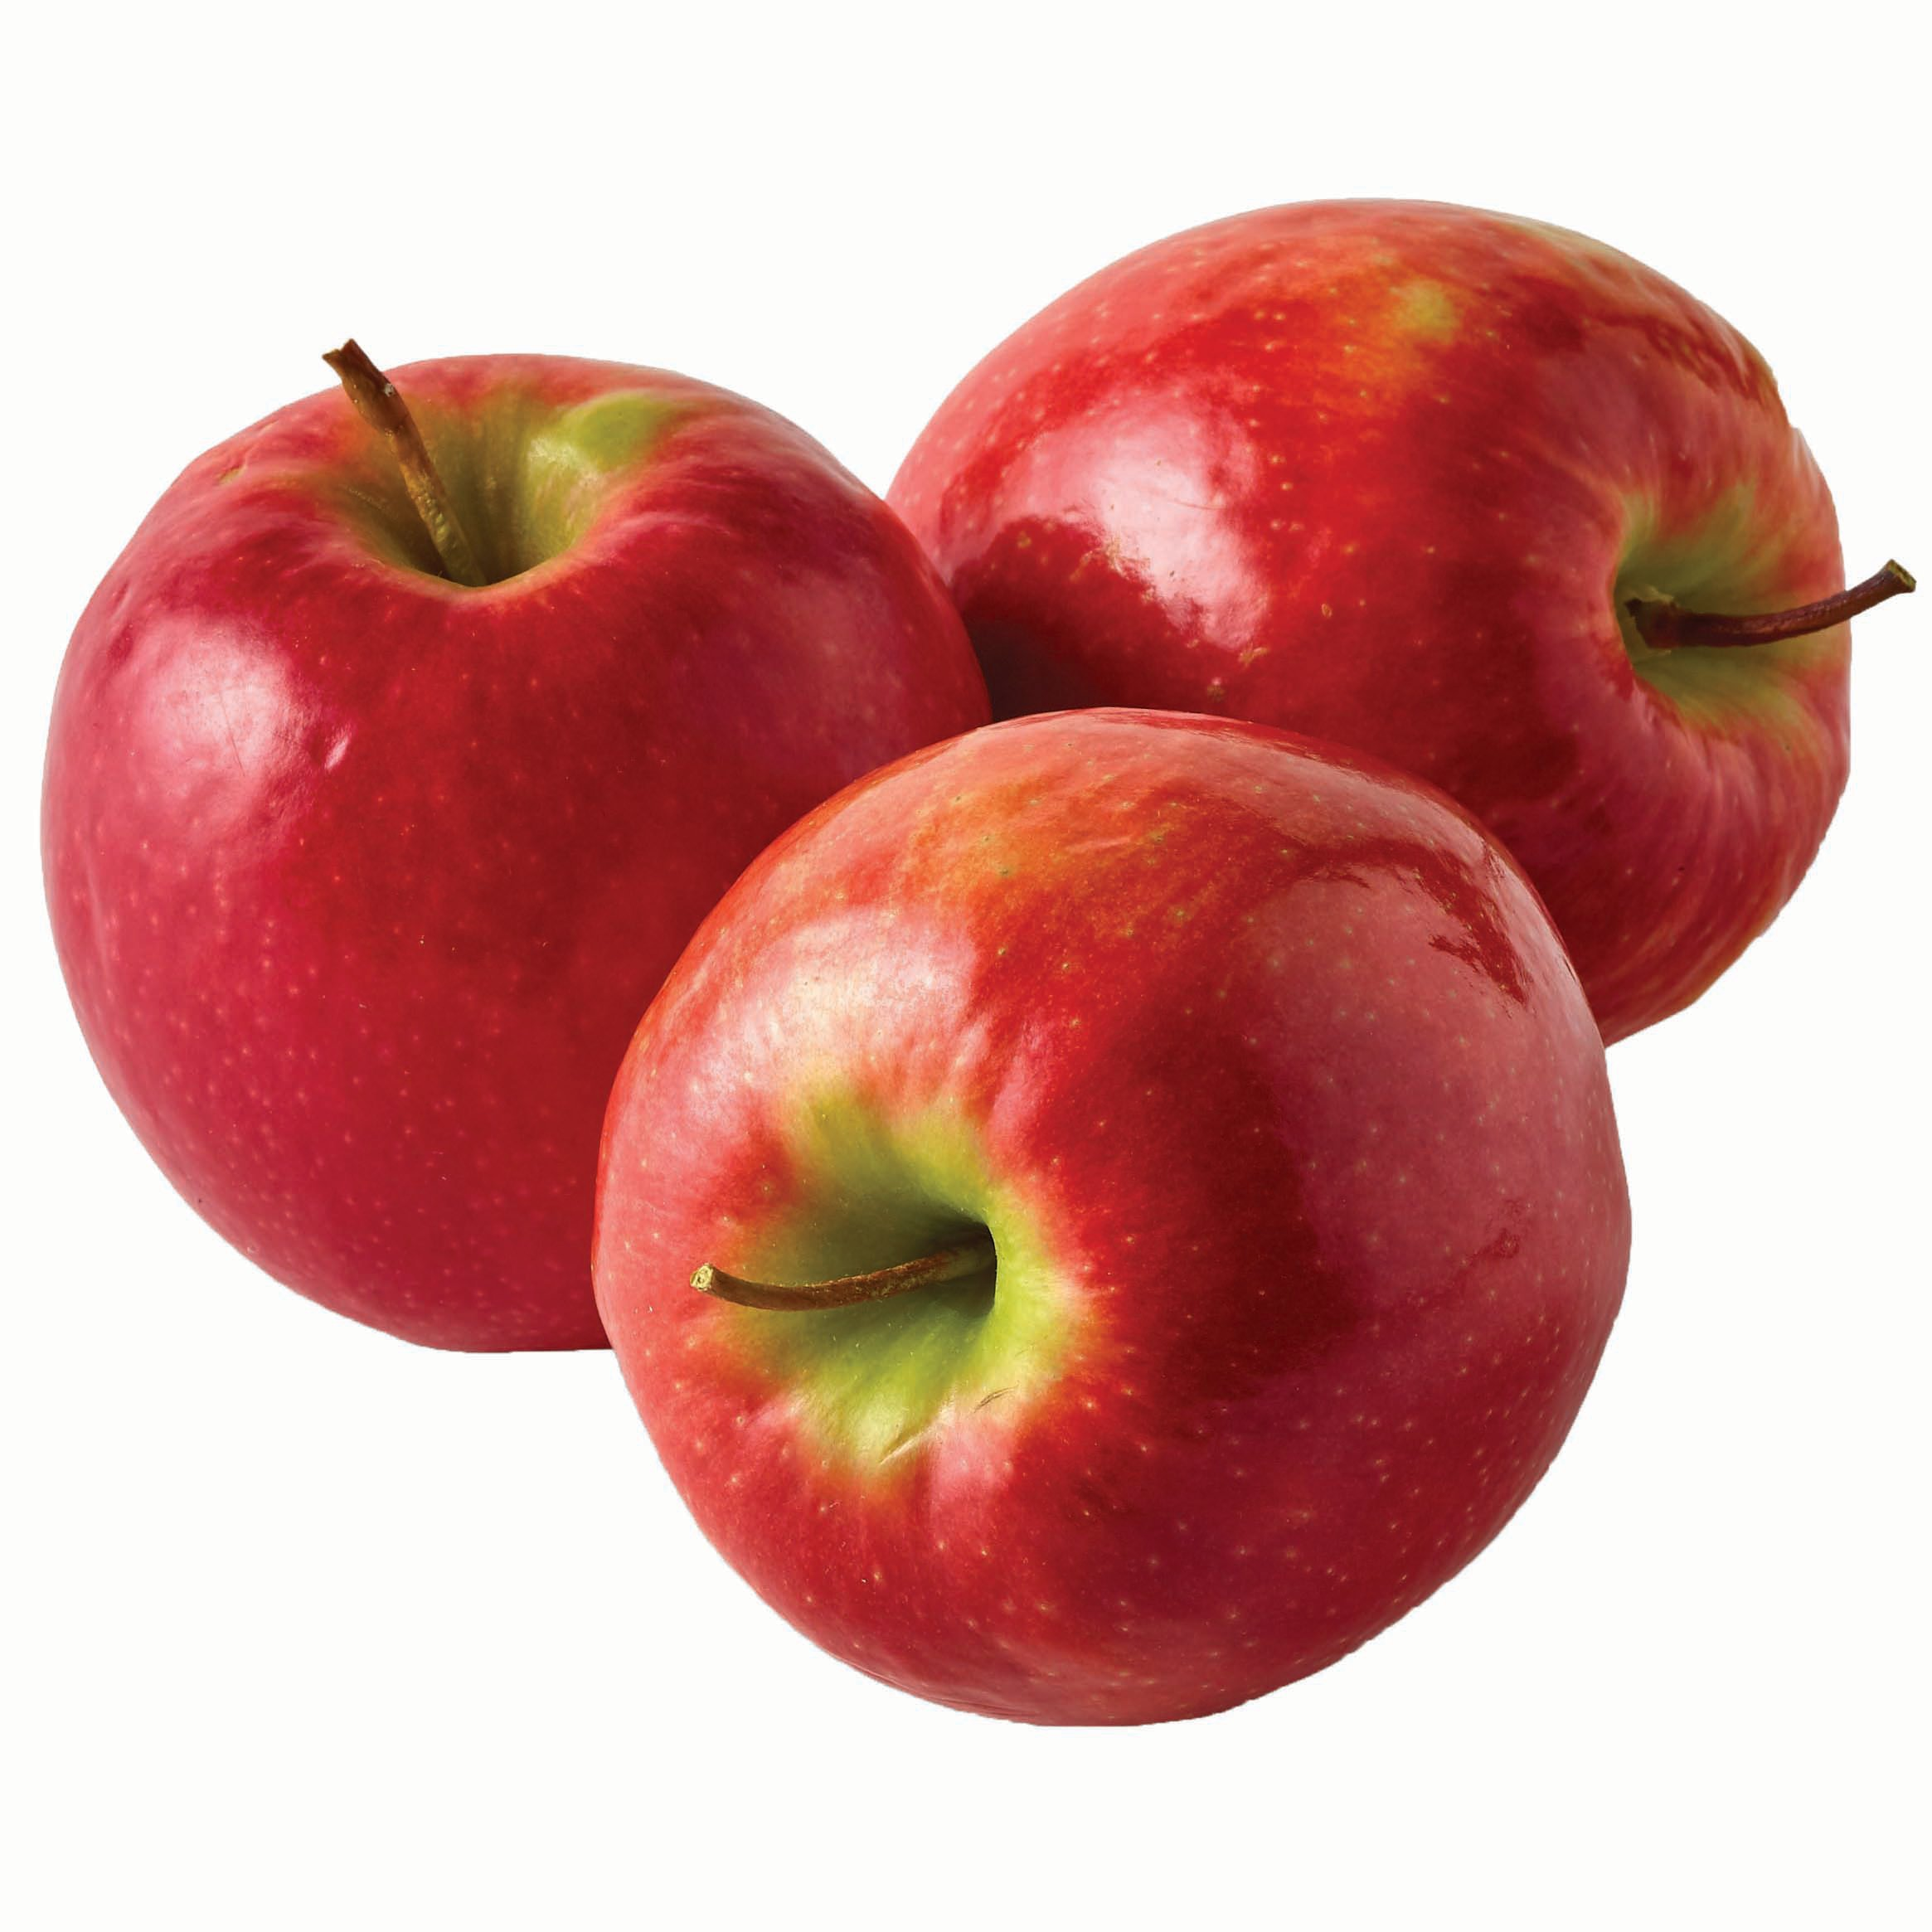

AI apple มีความมั่นใจ 100.00%.


In [22]:
test_path = ('/content/drive/My Drive/0/ap.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 28ms/step
apple tf.Tensor(0.0024527248, shape=(), dtype=float32) mangosteen tf.Tensor(0.99332434, shape=(), dtype=float32) pineapple tf.Tensor(0.0042230133, shape=(), dtype=float32)


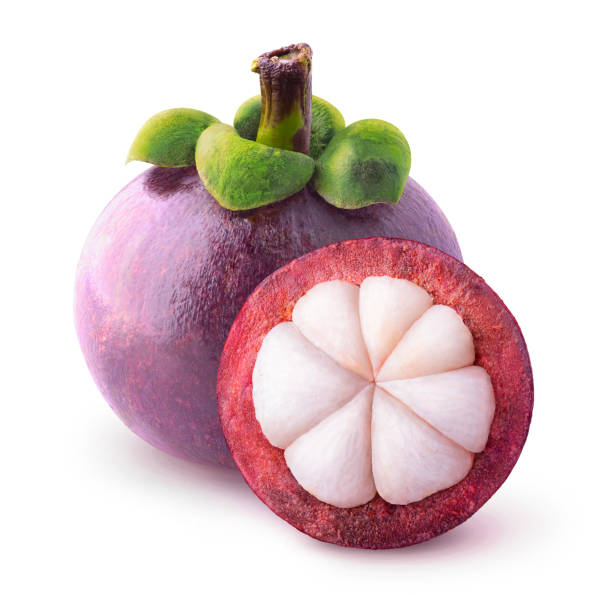

AI mangosteen มีความมั่นใจ 99.33%.


In [23]:
test_path = ('/content/drive/My Drive/0/ma.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

1/1 [==============================] - 0s 26ms/step
apple tf.Tensor(0.0028296364, shape=(), dtype=float32) mangosteen tf.Tensor(1.5228485e-07, shape=(), dtype=float32) pineapple tf.Tensor(0.99717027, shape=(), dtype=float32)


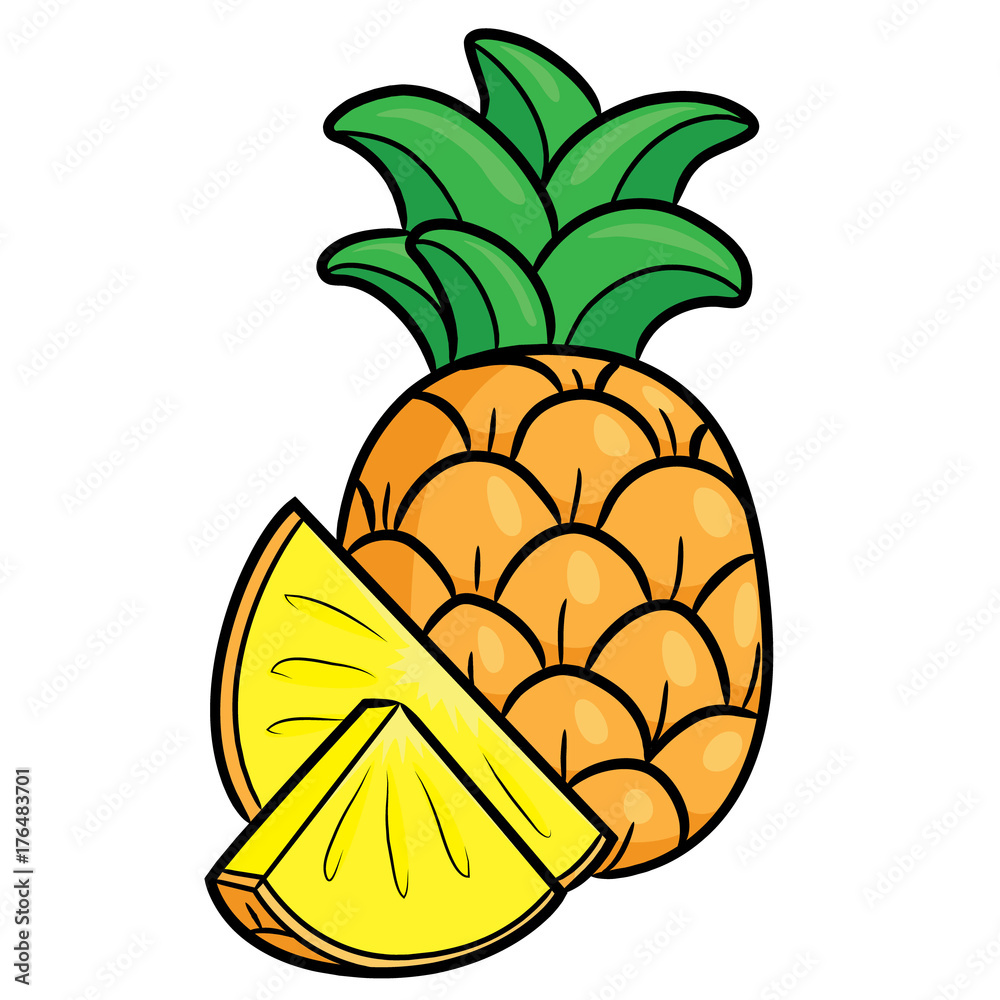

AI pineapple มีความมั่นใจ 99.72%.


In [24]:
test_path = ('/content/drive/My Drive/0/pi.jpg')
img = keras.preprocessing.image.load_img(
test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = predict_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("apple",score[0],"mangosteen",score[1],"pineapple",score[2])
display(Image(filename=test_path,width=180, height=180))
if score[0]==np.max(score) :
   fruit = "apple"
elif score[1]==np.max(score) :
   fruit = "mangosteen"
elif score[2]==np.max(score) :
   fruit = "pineapple"
print(
"AI {} มีความมั่นใจ {:.2f}%."
.format(fruit, 100 * np.max(score))
)

# Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred,labels=[0,1])
print("Confusion Matrix:")
print(cm)

NameError: ignored

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(cm,cmap="Reds",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

NameError: ignored

Normalized Confusion Matrix:
[[1. 0.]
 [0. 1.]]


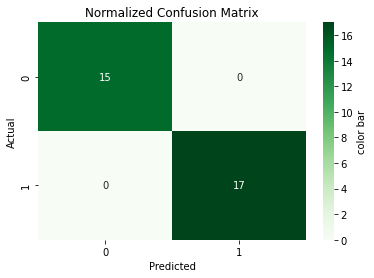

In [ ]:
# normalized
print("Normalized Confusion Matrix:")
cm_normalized=np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
print(cm_normalized)
sns.heatmap(cm,cmap="Greens",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Normalized Confusion Matrix")
plt.show()

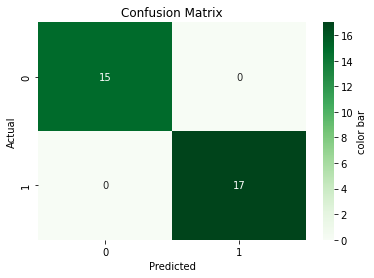

In [ ]:
# heatmap

sns.heatmap(cm,cmap="Greens",annot=True,
            cbar_kws={"orientation":"vertical","label":"color bar"},
            xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()